# Things to look into:
https://www.tensorflow.org/tutorials/images/data_augmentation <br>
make more data <br>
https://stats.stackexchange.com/questions/388859/is-it-possible-to-give-variable-sized-images-as-input-to-a-convolutional-neural <br> resizing
https://www.tensorflow.org/tutorials/interpretability/integrated_gradients

conda install -c conda-forge lime
conda install -c anaconda scikit-image

conda install -c conda-forge tqdm

!jupyter nbextension enable --py widgetsnbextension --sys-prefix

shap python
https://blog.dominodatalab.com/shap-lime-python-libraries-part-1-great-explainers-pros-cons/

skimage.util.montage is useful

oops, this is easier

https://github.com/marcotcr/lime/issues/453

Best explanation I can give for the lime problems -- huge reach here -- is that it "knows" that we're doing a binary problem and so is defaulting to zero.  But that doesn't seem at all justified and I hate it. 

Need to play with lime kernel width

Getting a sense of size for the images

In [14]:
from IPython.display import Audio
def yell_when_done():
    return Audio(url='https://www.soundhelix.com/examples/mp3/SoundHelix-Song-6.mp3',autoplay=True)
yell_when_done()

In [4]:
import PIL.Image as pim
import tqdm
import lime
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from skimage.color import rgb2gray
from skimage.color import gray2rgb


norm_fns=[os.path.join(r'train\NORMAL',s) for s in os.listdir(r'train\NORMAL')
         ]+[os.path.join(r'test\NORMAL',s) for s in os.listdir(r'test\NORMAL')
           ]+[os.path.join(r'val\NORMAL',s) for s in os.listdir(r'val\NORMAL')]
pneu_fns=[os.path.join(r'train\PNEUMONIA',s) for s in os.listdir(r'train\PNEUMONIA')
         ]+[os.path.join(r'test\PNEUMONIA',s) for s in os.listdir(r'test\PNEUMONIA')
           ]+[os.path.join(r'val\PNEUMONIA',s) for s in os.listdir(r'val\PNEUMONIA')]
# Not the best way, of course


img_det_df=pd.DataFrame(
    [(list(pim.open(fn).size)+[0]) for fn in norm_fns if fn.endswith('jpeg')]+[(
        list(pim.open(fn).size)+[1]) for fn in pneu_fns if fn.endswith('jpeg')]
    ,columns=['W','H','P']
)

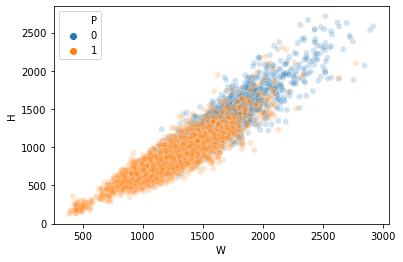

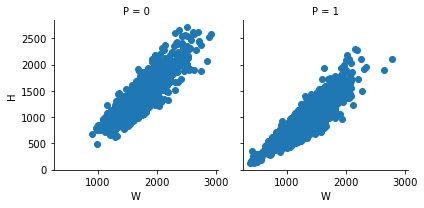

In [8]:
sns.scatterplot(x='W',y='H',hue='P',data=img_det_df,alpha=.2);
plt.show();
plt.clf();
plt.close();
g=sns.FacetGrid(img_det_df,col='P');
g.map(plt.scatter,'W','H');

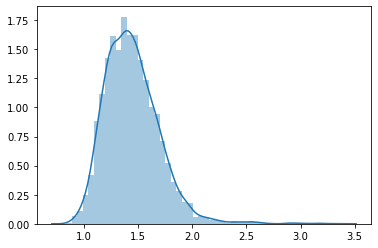

In [3]:
sns.distplot(img_det_df.W/img_det_df.H)

In [4]:
img_det_df.P.value_counts(normalize=True)

1    0.729679
0    0.270321
Name: P, dtype: float64

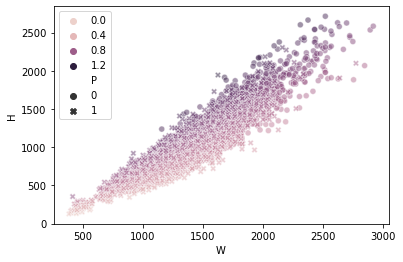

<Figure size 432x288 with 0 Axes>

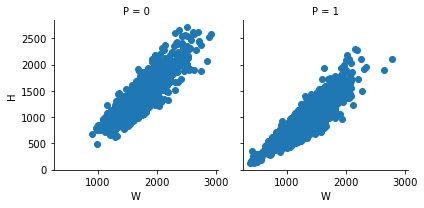

In [5]:
sns.scatterplot(x='W',y='H',hue=(img_det_df['H']/img_det_df['W']),style='P',data=img_det_df,alpha=.5)
plt.show()
plt.clf()
g=sns.FacetGrid(img_det_df,col='P')
g.map(plt.scatter,'W','H')

In [6]:
img_det_df.describe()

,W,H,P
count,5856.000000,5856.000000,5856.000000
mean,1327.880806,970.689037,0.729679
std,363.500922,383.392117,0.444164
min,384.000000,127.000000,0.000000
25%,1056.000000,688.000000,0.000000
50%,1281.000000,888.000000,1.000000
75%,1560.000000,1187.000000,1.000000
max,2916.000000,2713.000000,1.000000


# Initially just trying image resizing with padding

https://stackoverflow.com/questions/42467734/keras-how-to-use-imagedatagenerator-without-deforming-aspect-ratio

It looks like you're still unable to do this with the easy data importing method

In [9]:
train_data=ImageDataGenerator(rescale=1./255).flow_from_directory(
    'train',
    target_size=(224, 224),shuffle=False,class_mode='binary',
    #trying to figure out why my results were initially so miserable
    color_mode='grayscale',
    seed=60120, #seed shouldn't? matter,
    interpolation='nearest'    
    ,
    batch_size=624#using default interpolation scheme
)#using smallest image

train_images,train_labels=next(train_data)



test_data=ImageDataGenerator(rescale=1./255).flow_from_directory(
    'test',
    target_size=(224,224),shuffle=False,class_mode='binary',
    #technically having some data leakage maybe?
    
    color_mode='grayscale',
    seed=60120, #seed shouldn't? matter,
    interpolation='nearest'  #using default interpolation scheme,
    ,
    batch_size=624
    
)

test_images,test_labels=next(test_data)


#Not sure what's going on with the batch sizes yet.  
val_data=ImageDataGenerator(rescale=1./255).flow_from_directory(
    'val',
    target_size=(224,224),
    shuffle=False,class_mode='binary',
    #technically having some data leakage maybe?
    
    color_mode='grayscale',
    seed=60120, #seed shouldn't? matter,
    interpolation='nearest' 
    ,

    batch_size=624#using default interpolation scheme,
    
)

val_images,val_labels=next(val_data)

yell_when_done()

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [11]:
import numpy as np
images = np.concatenate((train_images,test_images,val_images))
labels=np.concatenate((train_labels,test_labels,val_labels))

In [540]:
[s.shape for s in (train_labels,test_labels,val_labels)]

[(624,), (624,), (16,)]

In [12]:
from sklearn.model_selection import train_test_split
X_model, X_test, y_model, y_test = train_test_split(images, labels, test_size=0.20, random_state=123)
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.20, random_state=123)
#same states as from Andy's

In [201]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

cnn = models.Sequential()
cnn.add(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      input_shape=train_images[0].shape,
                      padding='SAME'))

cnn.add(layers.MaxPooling2D((2, 2)))
# Output is 64*112*112



cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))

cnn.add(layers.MaxPooling2D((2, 2)))


cnn.add(layers.Flatten())

cnn.add(layers.Dense(32, activation='relu'))

cnn.add(layers.Dense(16, activation='relu'))
#adding another layer

cnn.add(layers.Dense(1, activation='sigmoid'))

#using same params as before

cnn.compile(loss='binary_crossentropy', #look into that further
            optimizer="adam",
            metrics=['acc',tf.keras.metrics.Recall()]) #recall to penalize false negatives



In [202]:
cnn.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 110, 110, 32)      18464     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 96800)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                3097632   
_________________________________________________________________
dense_16 (Dense)             (None, 16)               

In [203]:
from tensorflow.keras.callbacks import ModelCheckpoint
saving_weights = ModelCheckpoint(
    'weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)
#not actually sure what this does beyond the obvious

In [204]:
import tensorflow
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(patience=5)
nan_problem = tensorflow.keras.callbacks.TerminateOnNaN()
early_stop = tensorflow.keras.callbacks.EarlyStopping(patience=5)
csv_logger = tensorflow.keras.callbacks.CSVLogger('training.log')

In [205]:
cnn1 = cnn.fit(X_train,
               y_train,
               epochs=20,
               batch_size=32,
               validation_data=(X_val,y_val)
               ,
               callbacks=[csv_logger, early_stop, nan_problem, reduce_lr, saving_weights]
              )

#the warning that appears is apparently a bug found in v 2.1

yell_when_done()



Train on 808 samples, validate on 203 samples
Epoch 1/20
808/808 [==============================] - 71s 88ms/sample - loss: 0.5720 - acc: 0.6856 - recall_4: 0.1509 - val_loss: 0.3655 - val_acc: 0.9212 - val_recall_4: 0.8281
Epoch 2/20
808/808 [==============================] - 78s 97ms/sample - loss: 0.2464 - acc: 0.9171 - recall_4: 0.8340 - val_loss: 0.2387 - val_acc: 0.9163 - val_recall_4: 0.9688
Epoch 3/20
808/808 [==============================] - 106s 131ms/sample - loss: 0.1853 - acc: 0.9270 - recall_4: 0.8717 - val_loss: 0.1458 - val_acc: 0.9557 - val_recall_4: 0.9688
Epoch 4/20
808/808 [==============================] - 85s 105ms/sample - loss: 0.1223 - acc: 0.9592 - recall_4: 0.9283 - val_loss: 0.1231 - val_acc: 0.9655 - val_recall_4: 0.9219
Epoch 5/20
808/808 [==============================] - 102s 127ms/sample - loss: 0.0693 - acc: 0.9777 - recall_4: 0.9585 - val_loss: 0.1300 - val_acc: 0.9557 - val_recall_4: 0.9375
Epoch 6/20
808/808 [==============================] - 88s 1

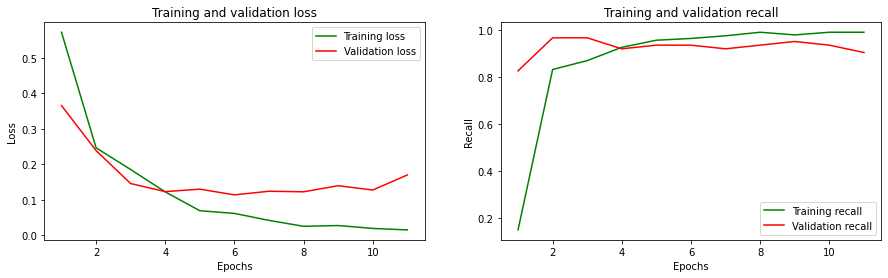

In [209]:
hist_cnn = cnn1.history
loss_values = hist_cnn['loss']
val_loss_values = hist_cnn['val_loss']
acc_values = hist_cnn['recall_4']
val_acc_values = hist_cnn['val_recall_4']


epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(15, 4))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs, acc_values, 'g', label='Training recall')
plt.plot(epochs, val_acc_values, 'r', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

In [210]:
X_lime=X_train.copy()[:4]
y_lime=y_train.copy()[:4]

In [211]:
type(cnn1)

tensorflow.python.keras.callbacks.History

In [612]:
preds=cnn.predict(X_train)

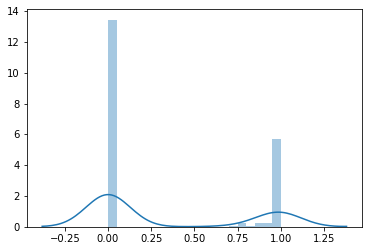

In [614]:
sns.distplot(preds,bins=20)

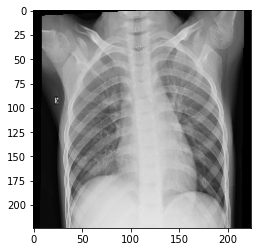

In [213]:
plt.imshow(X_lime[0].reshape(224,224),cmap='gray')

In [214]:
preds

array([[3.9454928e-04],
       [7.0507635e-06],
       [8.0344873e-04],
       [8.6683036e-07]], dtype=float32)

In [216]:
from tensorflow.keras.applications.imagenet_utils import decode_predictions
preds=cnn.predict(X_lime)
import skimage
from lime import lime_image

In [376]:
explainer=lime_image.LimeImageExplainer(random_state=60120)

In [412]:

def trial(x):
    
    x=rgb2gray(x).reshape(*rgb2gray(x).shape,1)
   
    return cnn.predict(x)
    
arr=np.apply_along_axis(gray2rgb,-2,X_train[0:16])
arr=arr.reshape(arr.shape[:-1])
print(arr.shape)
trial(arr)

(16, 224, 224, 3)


array([[3.9454986e-04],
       [7.0507635e-06],
       [8.0344907e-04],
       [8.6683036e-07],
       [1.0096900e-02],
       [6.4192092e-05],
       [1.0833236e-02],
       [9.9996877e-01],
       [4.9452217e-07],
       [9.2495495e-01],
       [4.2261379e-03],
       [5.2782593e-06],
       [1.0551918e-07],
       [9.9939311e-01],
       [4.2615764e-07],
       [9.9978405e-01]], dtype=float32)

In [413]:
test=explainer.explain_instance(arr[0],trial,labels=range(2),num_samples=100)

In [297]:
cnn.predict(X_train[:10])
trial(arr)

array([[3.9454986e-04],
       [7.0507635e-06],
       [8.0344907e-04],
       [8.6683036e-07],
       [1.0096900e-02],
       [6.4192092e-05],
       [1.0833236e-02],
       [9.9996877e-01],
       [4.9452217e-07],
       [9.2495495e-01],
       [4.2261379e-03],
       [5.2782593e-06]], dtype=float32)

In [255]:
#following the docs for faces&gradboost
temp,mask=test.get_image_and_mask(y_lime[0])

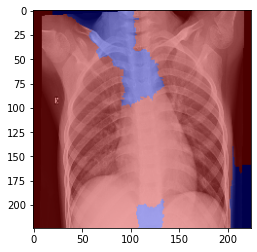

In [256]:
from skimage.color import label2rgb
plt.imshow(label2rgb(mask,temp))

In [440]:
lime_list=[]
for count,a in enumerate(arr):
    test=explainer.explain_instance(a,trial,num_samples=1000)
    temp,mask=test.get_image_and_mask(0)
    lime_list.append([temp,mask])    

In [443]:
lime_list_backup=lime_list.copy()

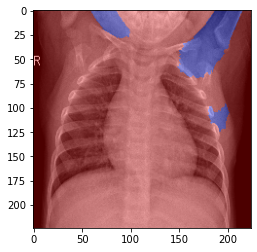

In [410]:
plt.imshow(label2rgb(mask,temp))
plt.show()
plt.close('all')

In [417]:
3//4

0

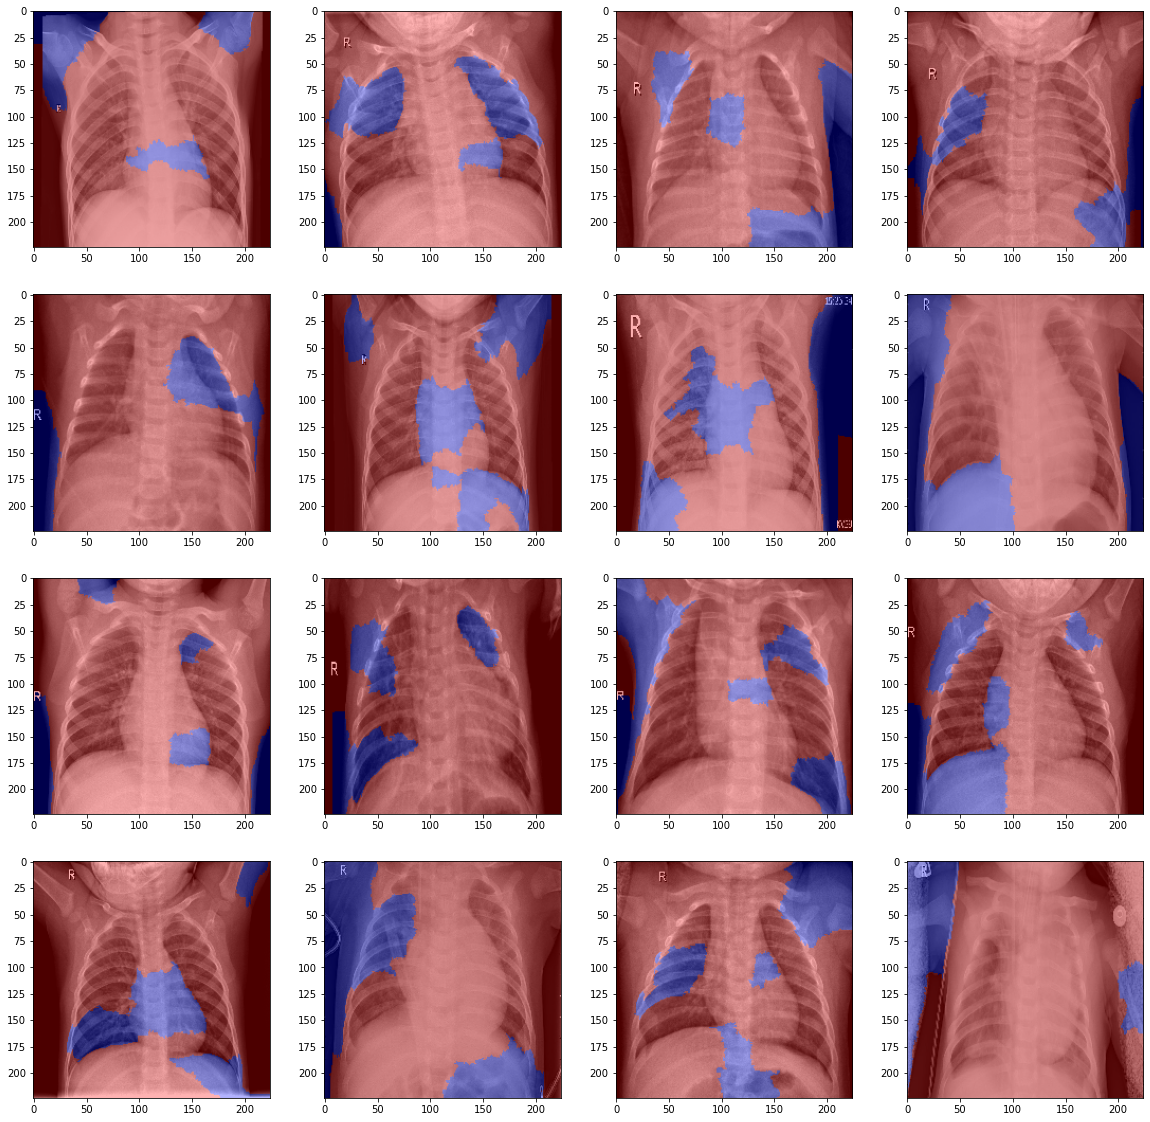

In [463]:
fig,axs=plt.subplots(4,4,figsize=(20,20))
for k,p in enumerate(lime_list):
    axs[k//4,k%4].imshow(label2rgb(*(p[::-1])))

(1011, 224)
(1011, 224, 224)
(1011, 224)


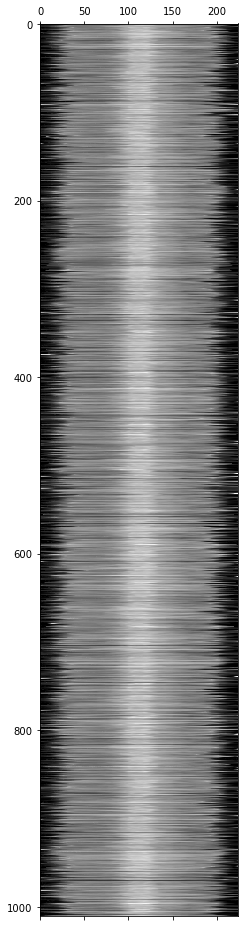

(1011, 224, 224)
(1011, 224)
(1011, 224, 224)
(224, 224)


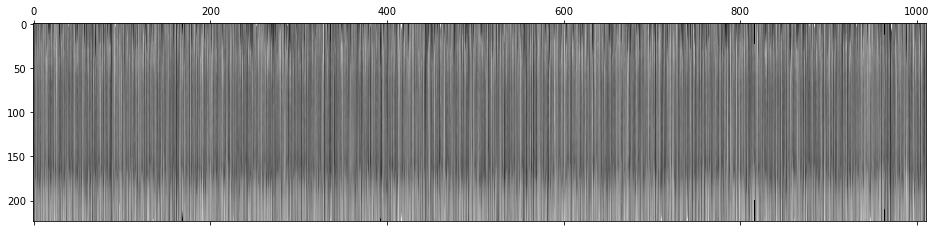

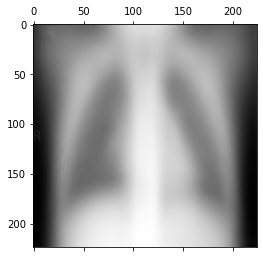

In [500]:
#using only training data
print(u.shape)
u=X_model[:,:,:,0]
print(u.shape)
u=u.mean(axis=1)
print(u.shape)
plt.matshow(u,cmap='gray')
plt.show()
plt.close('all')



v=X_model[:,:,:,0]
print(v.shape)
v=v.mean(axis=2)
print(v.shape)
plt.matshow(v.T,cmap='gray')

w=X_model[:,:,:,0]
print(w.shape)
w=w.mean(axis=0)
print(w.shape)
plt.matshow(w,cmap='gray')

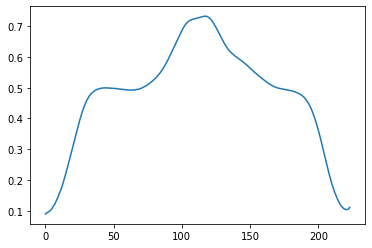

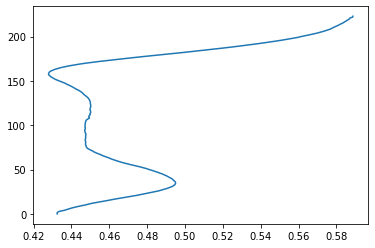

In [523]:
plt.plot(range(u.shape[1]),u.mean(axis=0))
plt.show()
plt.plot(v.mean(axis=0),range(v.shape[1]))

In [542]:
images.shape

(1264, 224, 224, 1)

In [531]:
y_model.shape
X_model.shape

(1011, 224, 224, 1)

(866, 224, 224, 1)
(866, 224, 224)
(866, 224)


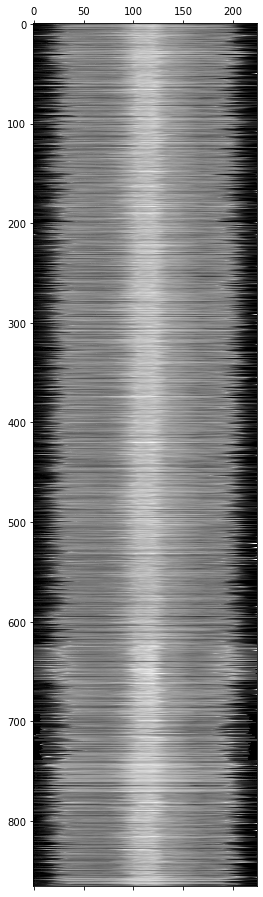

(866, 224, 224)
(866, 224)
(866, 224, 224)
(224, 224)


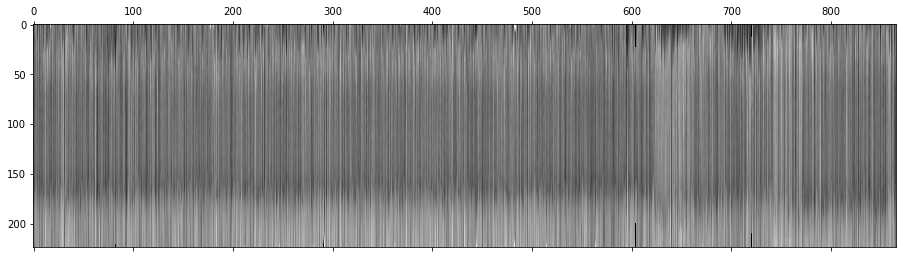

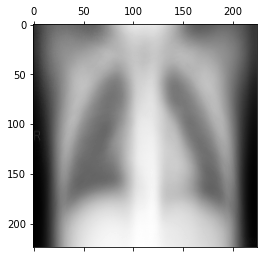

In [548]:
#here for just pneumon..ac
g=images[labels==0]

print(g.shape)
u=g[:,:,:,0]
print(u.shape)
u=u.mean(axis=1)
print(u.shape)
plt.matshow(u,cmap='gray')
plt.show()
plt.close('all')



v=g[:,:,:,0]
print(v.shape)
v=v.mean(axis=2)
print(v.shape)
plt.matshow(v.T,cmap='gray')

w=g[:,:,:,0]
print(w.shape)
w=w.mean(axis=0)
print(w.shape)
plt.matshow(w,cmap='gray')

(398, 224, 224, 1)
(398, 224, 224)
(398, 224)


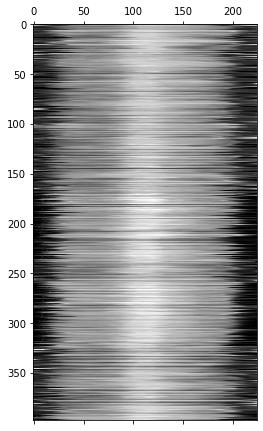

(398, 224, 224)
(398, 224)
(398, 224, 224)
(224, 224)


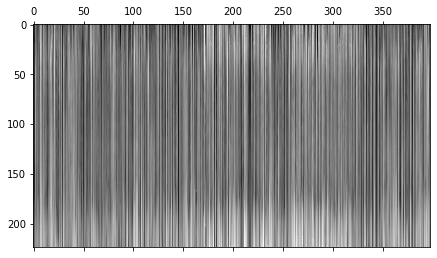

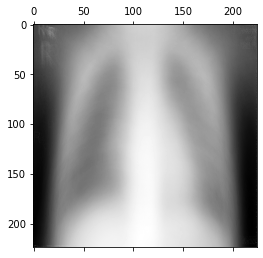

In [549]:
#here for just non-pneumon..ac
g=images[labels!=0]

print(g.shape)
u=g[:,:,:,0]
print(u.shape)
u=u.mean(axis=1)
print(u.shape)
plt.matshow(u,cmap='gray')
plt.show()
plt.close('all')



v=g[:,:,:,0]
print(v.shape)
v=v.mean(axis=2)
print(v.shape)
plt.matshow(v.T,cmap='gray')

w=g[:,:,:,0]
print(w.shape)
w=w.mean(axis=0)
print(w.shape)
plt.matshow(w,cmap='gray')

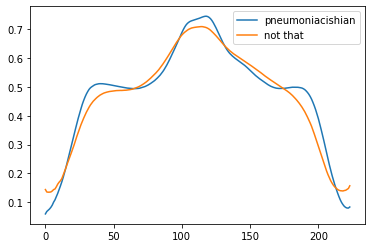

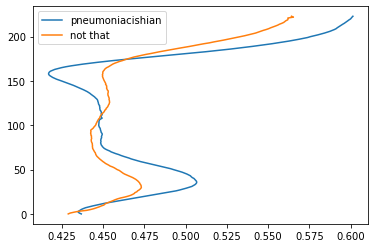

In [557]:
g=images[labels!=0]
u2=g[:,:,:,0]
u2=u2.mean(axis=1)
v2=g.mean(axis=2)


g=images[labels==0]
u1=g[:,:,:,0]
u1=u1.mean(axis=1)
v1=g.mean(axis=2)


plt.plot(range(u1.shape[1]),u1.mean(axis=0),label='pneumoniacishian')
plt.plot(range(u2.shape[1]),u2.mean(axis=0),label='not that')
plt.legend()
plt.show()


plt.plot(v1.mean(axis=0),range(v1.shape[1]),label='pneumoniacishian')
plt.plot(v2.mean(axis=0),range(v2.shape[1]),label='not that')
plt.legend()


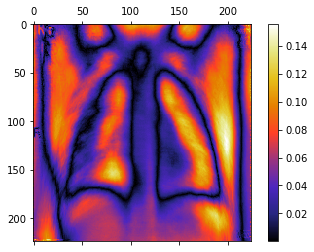

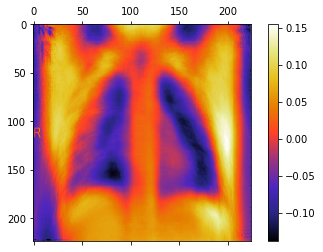

In [570]:

g=images[labels!=0]
f=images[labels==0]
g=g[:,:,:,0]
f=f[:,:,:,0]
q=f.mean(axis=0)-g.mean(axis=0)

fig,ax=plt.subplots()
r=ax.matshow(abs(q),cmap='CMRmap')
fig.colorbar(r)
plt.show()

fig,ax=plt.subplots()
r=ax.matshow(q,cmap='CMRmap')
fig.colorbar(r)

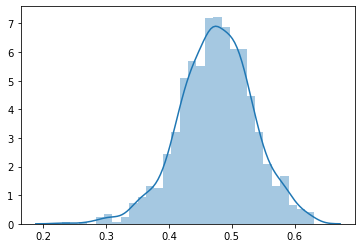

In [580]:
sns.distplot(images[:,:,:,0].mean(axis=1).mean(axis=1))

In [585]:
images.shape

(1264, 224, 224, 1)

array([[0.19509755, 0.19904386, 0.21232875, ..., 0.23341058, 0.22678982,
        0.22029307],
       [0.1895069 , 0.1953922 , 0.20424983, ..., 0.21657941, 0.22661296,
        0.21784522],
       [0.18929587, 0.19395892, 0.20191978, ..., 0.23111169, 0.2216118 ,
        0.2189776 ],
       ...,
       [0.04559438, 0.03912566, 0.04077   , ..., 0.04791186, 0.04330467,
        0.05078793],
       [0.0463917 , 0.05710778, 0.06398293, ..., 0.04327365, 0.04227155,
        0.05242603],
       [0.04438438, 0.05160395, 0.04099956, ..., 0.04518788, 0.04462635,
        0.05103921]], dtype=float32)

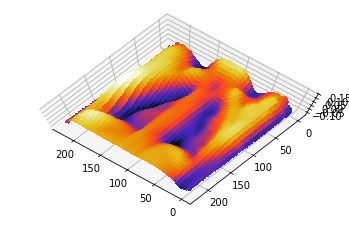

In [610]:
X,Y=np.meshgrid(np.arange(0,224),np.arange(0,224))
Z=images[:,:,:,0].mean(axis=0)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(80,130)
surf = ax.plot_surface(X, Y, q, cmap='CMRmap',
                       linewidth=1, antialiased=False)


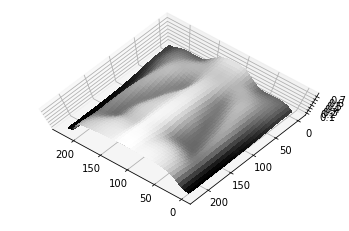

In [611]:
X,Y=np.meshgrid(np.arange(0,224),np.arange(0,224))
Z=images[:,:,:,0].mean(axis=0)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.view_init(80,130)
surf = ax.plot_surface(X, Y, Z, cmap='gray',
                       linewidth=1, antialiased=False)